<a href="https://colab.research.google.com/github/Rosharma307/Module_6/blob/main/module_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Seoul Bike Rental Analysis Documentation

This document provides an overview of the analysis and modeling performed on the Seoul Bike Rental dataset.
The goal of this project is to explore the dataset, perform regression analysis to predict bike rental counts, and visualize relevant insights.

##Business Context
Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error





In [ ]:
from google.colab import drive                    # Mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 'latin-1' encoding
encoding = 'latin-1'

# Read the CSV file with the specified encoding
df = pd.read_csv("/content/drive/MyDrive/SeoulBikeData.csv", encoding=encoding)

# Check the first few rows of the DataFrame
print(df.head())


         Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [ ]:
df.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


##Data Exploration and Analysis


In [ ]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract datetime features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Summary statistics for numeric columns
numeric_cols = ['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)',
                'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
print(df[numeric_cols].describe())



       Rented Bike Count  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
count        8760.000000      8760.000000  8760.000000       8760.000000   
mean          704.602055        12.882922    58.226256          1.724909   
std           644.997468        11.944825    20.362413          1.036300   
min             0.000000       -17.800000     0.000000          0.000000   
25%           191.000000         3.500000    42.000000          0.900000   
50%           504.500000        13.700000    57.000000          1.500000   
75%          1065.250000        22.500000    74.000000          2.300000   
max          3556.000000        39.400000    98.000000          7.400000   

       Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
count       8760.000000                8760.000000              8760.000000   
mean        1436.825799                   4.073813                 0.569111   
std          608.298712                  13.060369                 0.868746   

<ipython-input-17-1a6cab3abbc3>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


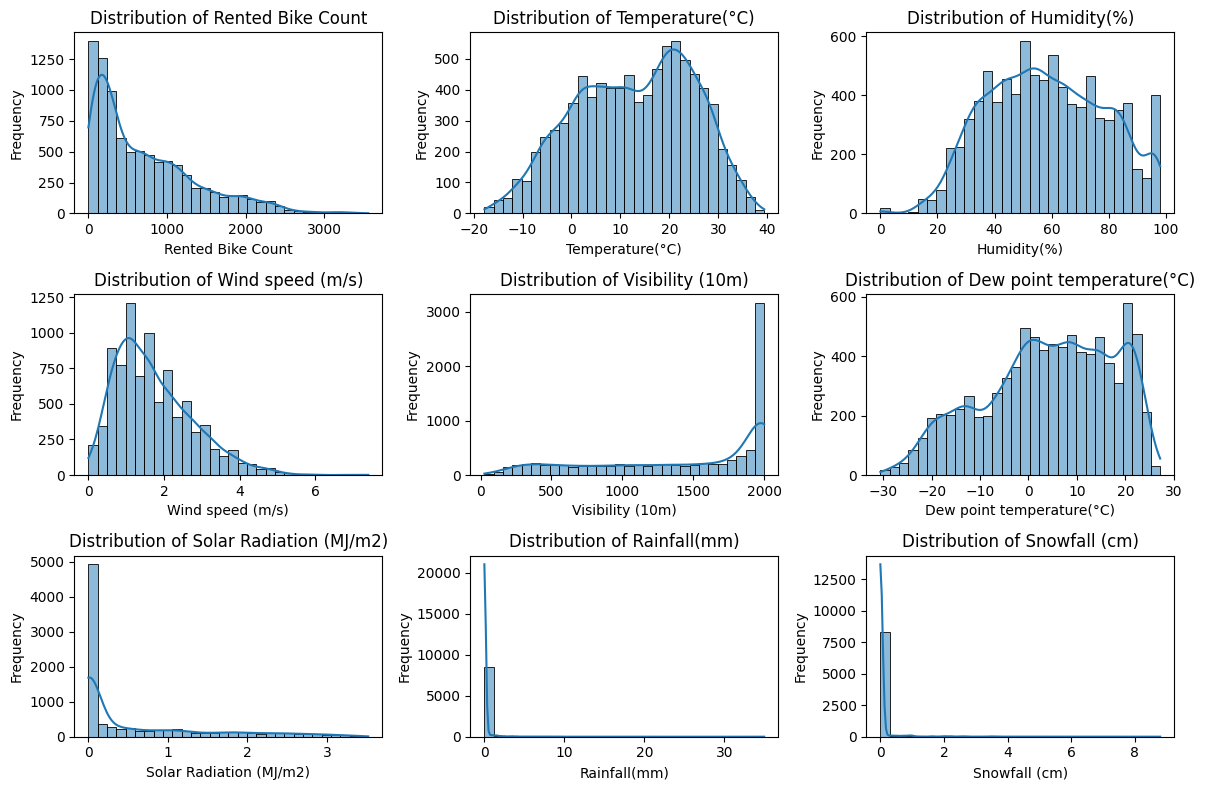

In [ ]:
# Histograms for numeric columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()






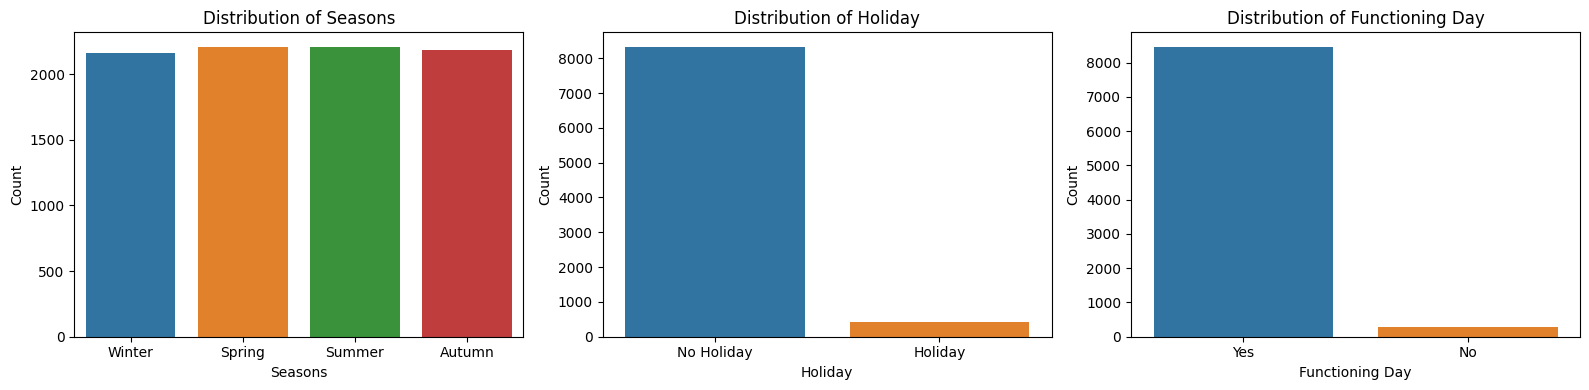

In [ ]:
# Bar plots for categorical columns
categorical_cols = ['Seasons', 'Holiday', 'Functioning Day']

plt.figure(figsize=(16, 4))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

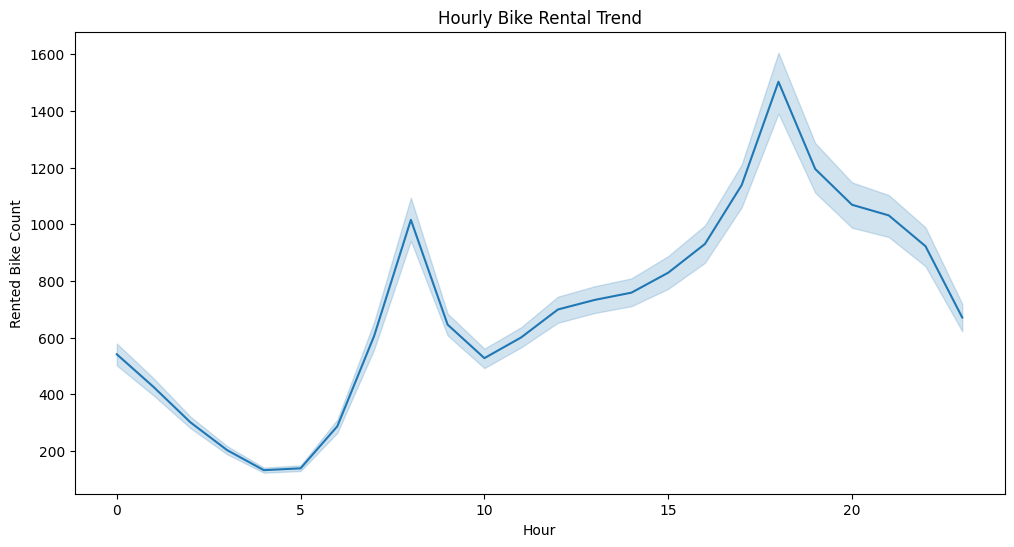

In [ ]:
# Hourly bike rental trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Hour', y='Rented Bike Count')
plt.title('Hourly Bike Rental Trend')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.show()



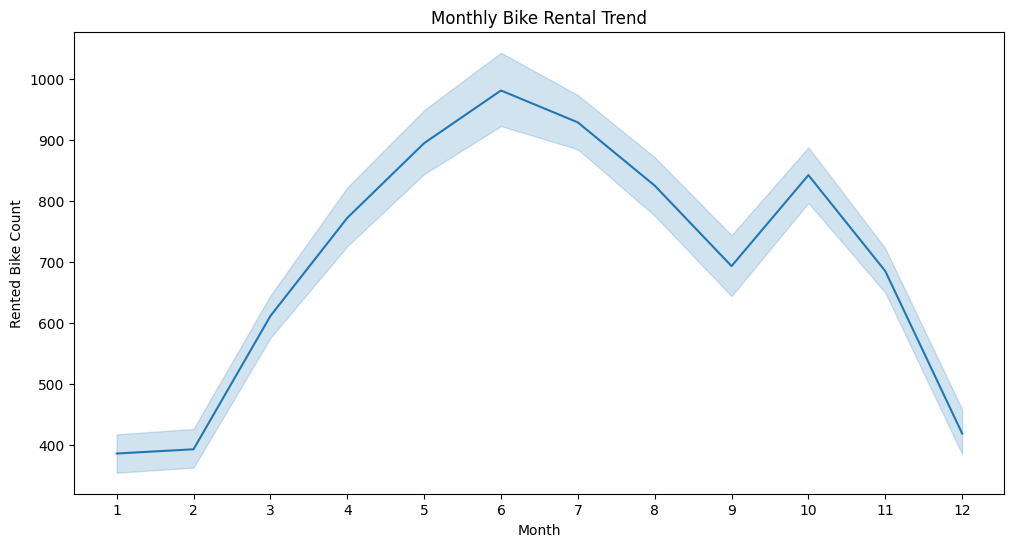

In [ ]:
# Monthly bike rental trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='Rented Bike Count')
plt.title('Monthly Bike Rental Trend')
plt.xlabel('Month')
plt.ylabel('Rented Bike Count')
plt.xticks(range(1, 13))
plt.show()

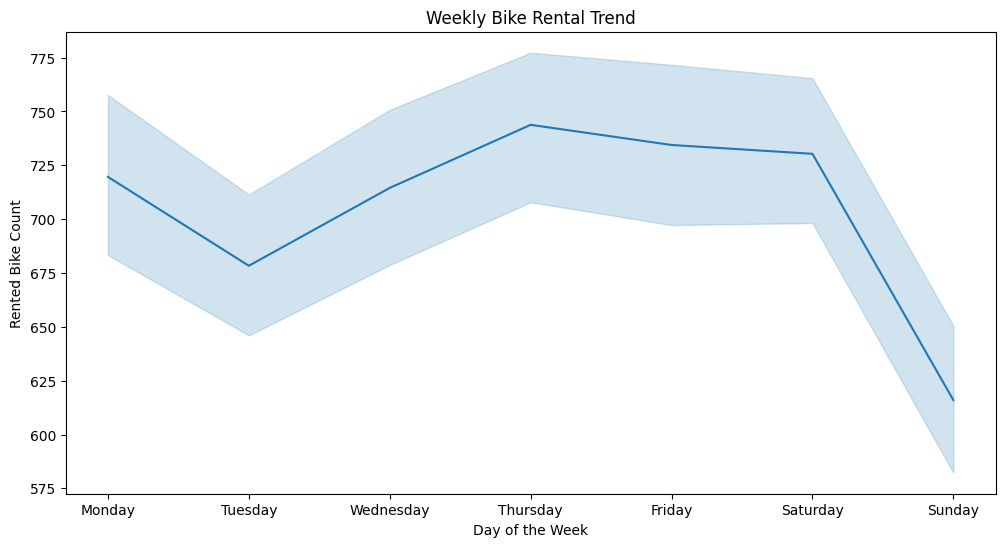

In [ ]:
# Weekly bike rental trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='DayOfWeek', y='Rented Bike Count')
plt.title('Weekly Bike Rental Trend')
plt.xlabel('Day of the Week')
plt.ylabel('Rented Bike Count')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()



##Data Preprocessing

In [ ]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()
print(missing_values)


Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
Year                         0
Month                        0
DayOfWeek                    0
dtype: int64


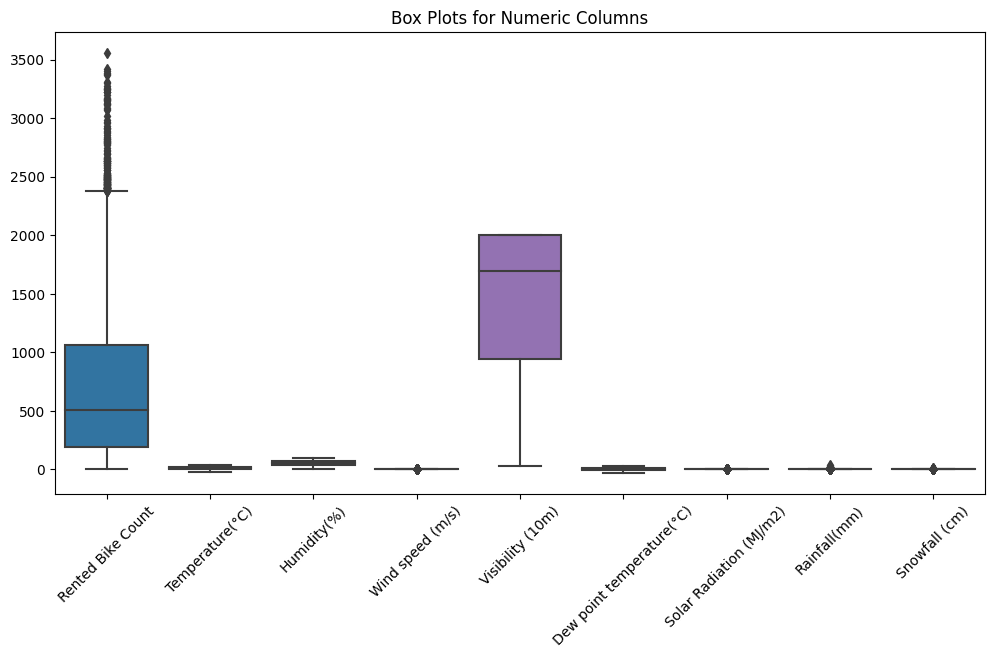

In [ ]:
# Create box plots for numeric columns to visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title('Box Plots for Numeric Columns')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#Feature Engineering:
# Convert the 'Hour' column to string format
df['Hour'] = df['Hour'].astype(str)

# Now, you can split the 'Hour' column to create the 'hour_of_day' feature
df['hour_of_day'] = df['Hour'].apply(lambda x: x.split(':')[0]).astype(int)



##Feature Selection

In [ ]:
# Calculate the correlation between features and the target variable
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Rented Bike Count'].abs().sort_values(ascending=False)
print(correlation_with_target)


Rented Bike Count            1.000000
Temperature(°C)              0.538558
hour_of_day                  0.410257
Dew point temperature(°C)    0.379788
Solar Radiation (MJ/m2)      0.261837
Year                         0.215162
Humidity(%)                  0.199780
Visibility (10m)             0.199280
Snowfall (cm)                0.141804
Rainfall(mm)                 0.123074
Wind speed (m/s)             0.121108
Month                        0.070861
DayOfWeek                    0.021577
Name: Rented Bike Count, dtype: float64


<ipython-input-29-ca1a76748a39>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


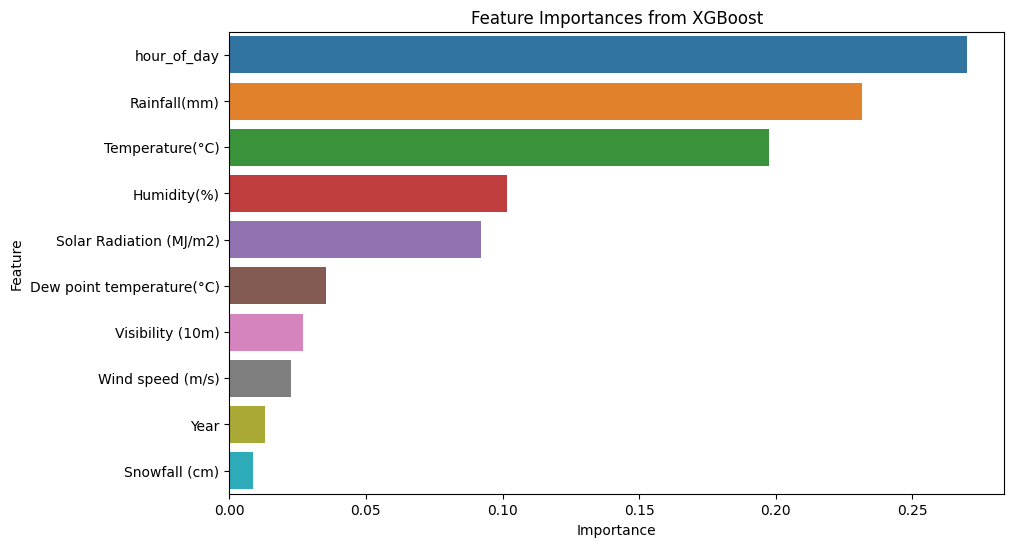

Top 5 Features by Importance:
['hour_of_day', 'Rainfall(mm)', 'Temperature(°C)', 'Humidity(%)', 'Solar Radiation (MJ/m2)']


In [ ]:
# Split the data into training and testing sets
X = df[['Temperature(°C)', 'hour_of_day', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Year', 'Humidity(%)', 'Visibility (10m)', 'Snowfall (cm)', 'Rainfall(mm)', 'Wind speed (m/s)']]
y = df['Rented Bike Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit an XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importances from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Select the top N features based on importance scores
top_n_features = feature_importance_df['Feature'].head(5).tolist()
print("Top 5 Features by Importance:")
print(top_n_features)


In [ ]:
# Select the features based on your chosen method (e.g., feature importance)
selected_features = ['Temperature(°C)', 'hour_of_day', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Year']

# Split the data into training and testing sets
X = df[selected_features]  # Use the selected features
y = df['Rented Bike Count']  # Target variable

# Specify the test_size (e.g., 0.2 for an 80-20 split) and random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (7008, 5)
Shape of X_test: (1752, 5)
Shape of y_train: (7008,)
Shape of y_test: (1752,)


In [ ]:
# Fit an XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the test data using XGBoost
y_pred = model.predict(X_test)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 356.50067848323096
Mean Absolute Error (MAE): 217.50739917618364


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define a parameter distribution for random search
param_dist = {
    'n_estimators': stats.randint(100, 1000),  # Randomly sample from 100 to 1000
    'max_depth': stats.randint(3, 10),       # Randomly sample from 3 to 10
    'learning_rate': [0.01, 0.1, 0.2],      # Specify specific values
    # Add other hyperparameters and distributions as needed
}

# Create an XGBoost regressor
xgb = XGBRegressor(random_state=42)

# Create a random search object
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist,
                                   n_iter=50, scoring='neg_mean_squared_error',
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)

# Fit the random search to your data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Get the best estimator (model)
best_model = random_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Calculate RMSE and MAE for the tuned model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE) after tuning: {rmse}")
print(f"Mean Absolute Error (MAE) after tuning: {mae}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 872}
Root Mean Squared Error (RMSE) after tuning: 333.0882925770878
Mean Absolute Error (MAE) after tuning: 206.53144557182102


In [ ]:
df.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Year', 'Month', 'DayOfWeek',
       'hour_of_day'],
      dtype='object')

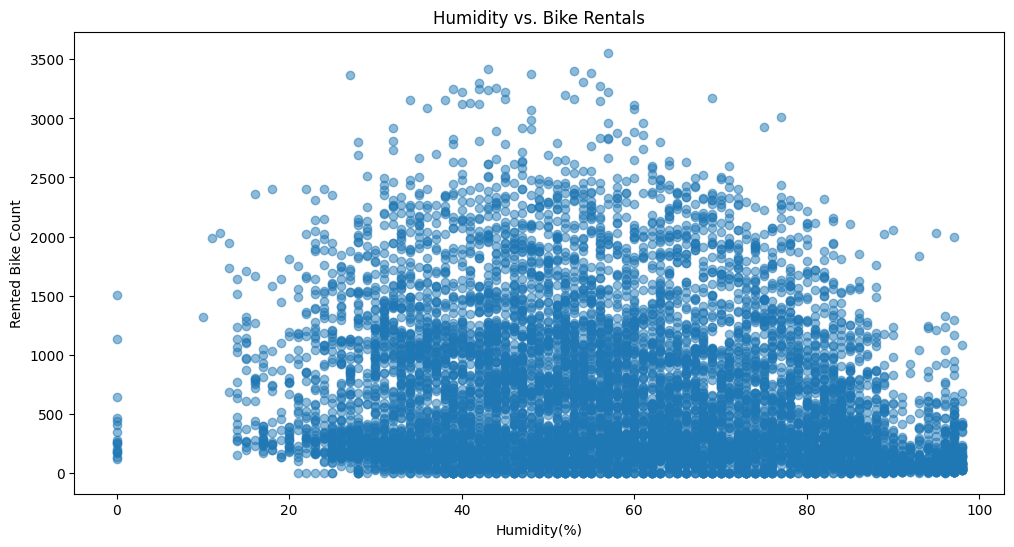

In [ ]:
##Humidity vs. Bike Rentals
plt.figure(figsize=(12, 6))
plt.scatter(df['Humidity(%)'], df['Rented Bike Count'], alpha=0.5)
plt.title('Humidity vs. Bike Rentals')
plt.xlabel('Humidity(%)')
plt.ylabel('Rented Bike Count')
plt.show()


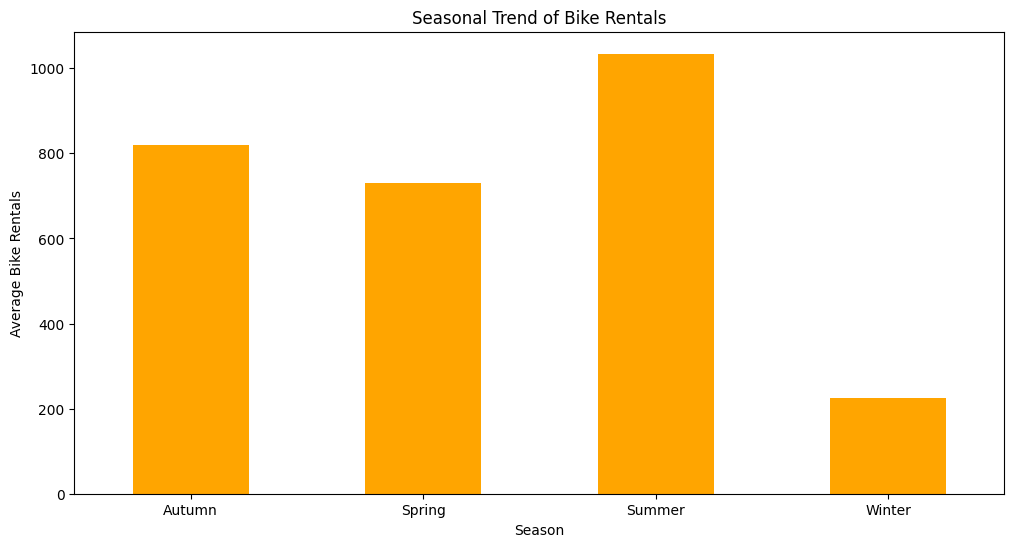

In [ ]:
##Seasonal Trend of Bike Rentals
seasonal_rentals = df.groupby('Seasons')['Rented Bike Count'].mean()
plt.figure(figsize=(12, 6))
seasonal_rentals.plot(kind='bar', color='orange')
plt.title('Seasonal Trend of Bike Rentals')
plt.xlabel('Season')
plt.ylabel('Average Bike Rentals')
plt.xticks(rotation=0)
plt.show()


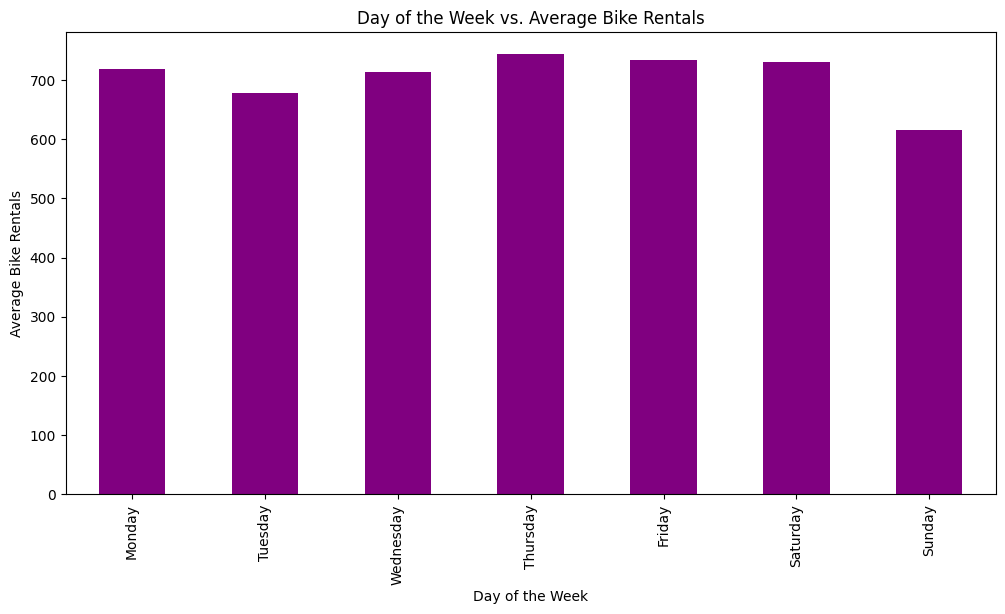

In [ ]:
##Day of the Week vs. Bike Rentals
day_of_week_rentals = df.groupby('DayOfWeek')['Rented Bike Count'].mean()
plt.figure(figsize=(12, 6))
day_of_week_rentals.plot(kind='bar', color='purple')
plt.title('Day of the Week vs. Average Bike Rentals')
plt.xlabel('Day of the Week')
plt.ylabel('Average Bike Rentals')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


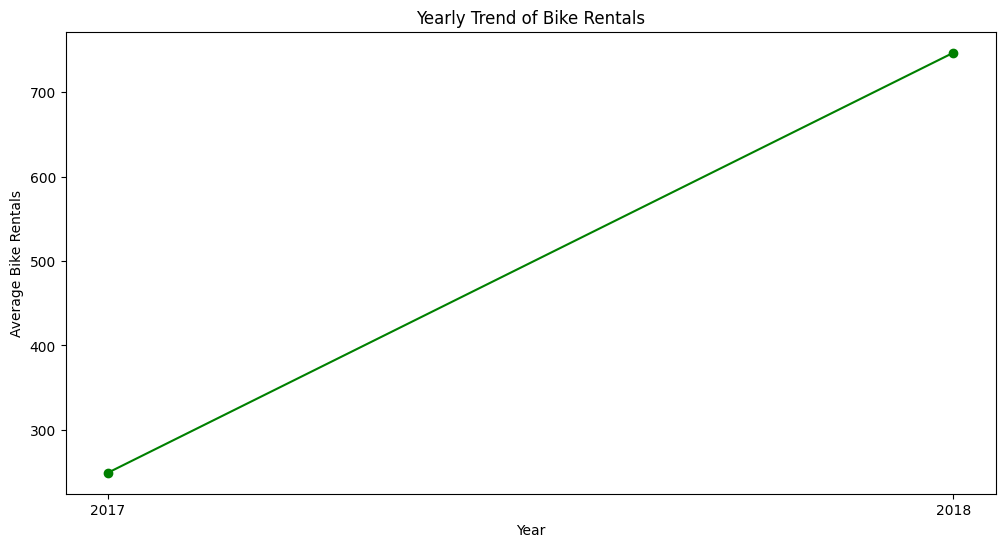

In [ ]:
##yearly trends of bike riders
yearly_rentals = df.groupby('Year')['Rented Bike Count'].mean()
plt.figure(figsize=(12, 6))
yearly_rentals.plot(kind='line', marker='o', color='green')
plt.title('Yearly Trend of Bike Rentals')
plt.xlabel('Year')
plt.ylabel('Average Bike Rentals')
plt.xticks(yearly_rentals.index)
plt.show()


##Conclusion
###On the basis of above analysis these conclusion are made:

###1.Humidity vs. Bike Rentals
As you can see in visualization as the humidity increases number of bikers decreases.

###2.Seasonal Trend of Bike Rentals
Bikers highly prefer summer season but decent numbers of Bikers are also active in spring and Autumn.
hence, Except Winters large number of people rents the bike.

###3.Day of the Week vs. Bike Rentals
Almost all the days has similar bikers but the number decreases on sunday maybe because of holiday.

###4.yearly trends of bike riders

As we can see in line chart the population of bikers increases drastically over a year
which makes bussiness revanue and increases profit too.
